### Fetch Data from FBRef API

First get the API key

In [52]:
from python.fbref import FBRAPIDataset
import requests
import time

dataset = FBRAPIDataset()

Get the country codes and league ids

In [53]:
target_countries = ['England', 'Spain', 'Italy', 'France', 'Germany']
target_leagues = ['Premier League', 'La Liga', 'Serie A', 'Ligue 1', 'Bundesliga']
# target_countries = ['England']
# target_leagues = ['Premier League']

country_ids = dataset.get_country_ids(target_countries)
league_ids = dataset.get_league_ids(target_leagues, country_ids)
#season_ids = dataset.get_season_ids(league_ids) POSSIBLY USE THIS LATER, BUT FOR NOW WE ARE JUST USING 2018-2019 UNTIL 2023-2024
season_ids = ['2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024']

print("Country IDs:", country_ids, "league ids", league_ids, "season ids", season_ids)

Country IDs: ['ENG', 'FRA', 'GER', 'ITA', 'ESP'] league ids [9, 13, 11, 208, 12] season ids ['2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024']


Fetch data for each league and season

In [54]:
# Loop over each combination of league and season
import json
import os

stats = []
for league_id in league_ids:
    for season_id in season_ids:
        stats.extend(dataset.fetch_team_stats(league_id, season_id))

# Save raw data to a JSON file for future use in the ./data directory
output_path = os.path.join('./data', "raw_team_stats.json")
with open(output_path, "w") as f:
    json.dump(stats, f, indent=2)

print(f"Raw data saved to {output_path}")

Failed to fetch for league 208, season 2018-2019
Failed to fetch for league 208, season 2019-2020
Raw data saved to ./data\raw_team_stats.json


Flatten dictionary and save to csv file

In [55]:
import pandas as pd

with open("./data/raw_team_stats.json", "r") as f:
    raw_data = json.load(f)

# Use the static method to flatten each record
flattened_data = [FBRAPIDataset.flatten_dict(record) for record in raw_data]

# Optionally, convert the flattened data to a DataFrame for easier inspection
df_flat = pd.DataFrame(flattened_data)
df_flat.to_csv("./data/team_stats.csv", index=False)
print("Structured data saved to team_stats.csv")

Structured data saved to team_stats.csv


### Attach ELO ratings to csv files as target column

In [57]:
import importlib
import python.elo

# Reload the module
importlib.reload(python.elo)

# Use the class directly from the module
elo_dataset = python.elo.ELODataset(['2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024'])

# Load your team season stats CSV file
team_stats = pd.read_csv("data/team_stats.csv")

# Retrieve Elo ratings based on the team_stats data.
ratings_df = elo_dataset.get_ratings(team_stats)
print("ELO Ratings DataFrame:")
print(ratings_df.head())

# Merge the Elo ratings into the team_stats DataFrame.
merged_team_stats = elo_dataset.merge_ratings(team_stats)
print("Merged Dataset with Elo column:")
print(merged_team_stats.head())

# Save the merged dataset to a CSV file.
merged_team_stats.to_csv("data/team_stats_with_elo.csv", index=False)


ELO Ratings DataFrame:
  meta_data_team_name  season_id          Elo
0             Arsenal  2018-2019  1870.875122
1         Bournemouth  2018-2019  1694.885864
2            Brighton  2018-2019  1620.250977
3             Burnley  2018-2019  1685.654907
4        Cardiff City  2018-2019          NaN
Merged Dataset with Elo column:
  meta_data_team_id meta_data_team_name  stats_stats_roster_size  \
0          18bb7c10             Arsenal                       28   
1          4ba7cbea         Bournemouth                       28   
2          d07537b9            Brighton                       21   
3          943e8050             Burnley                       23   
4          75fae011        Cardiff City                       25   

   stats_stats_matches_played  stats_stats_ttl_gls  stats_stats_ttl_ast  \
0                          38                   69                   52   
1                          38                   55                   43   
2                          38      

### Normalize Data

In [58]:
import importlib
import python.dataset

# Force reload the module to get the latest changes
importlib.reload(python.dataset)

# Now import the function
from python.dataset import load_and_normalize_data

# Load and normalize the data
normalized_data = load_and_normalize_data(
    csv_path="data/team_stats_with_elo.csv", 
    output_path="data/team_stats_with_elo_normalized.csv"
)

# Display the first few rows to verify
print(normalized_data.head())


  meta_data_team_id meta_data_team_name  league_id  season_id  \
0          18bb7c10             Arsenal          9  2018-2019   
1          4ba7cbea         Bournemouth          9  2018-2019   
2          d07537b9            Brighton          9  2018-2019   
3          943e8050             Burnley          9  2018-2019   
4          75fae011        Cardiff City          9  2018-2019   

   stats_stats_roster_size  stats_stats_matches_played  stats_stats_ttl_gls  \
0                -0.207088                     0.44667             1.244576   
1                -0.207088                     0.44667             0.399594   
2                -2.167320                     0.44667            -0.807524   
3                -1.607254                     0.44667            -0.324677   
4                -1.047187                     0.44667            -0.928235   

   stats_stats_ttl_ast  stats_stats_ttl_non_pen_gls  stats_stats_ttl_xg  ...  \
0             1.479016                     1.383993   

Split Data

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Quick info about the data
print("Full dataset shape:", normalized_data.shape)
print("Columns in data:")
print(normalized_data.columns.tolist())

# Identify all numeric columns and then select those for features (excluding the Elo target)
numeric_cols = normalized_data.select_dtypes(exclude=['object']).columns.tolist()
features = [col for col in numeric_cols if col != "Elo"]
print("\nNumeric feature columns (excluding Elo):")
print(features)

# Split data into 70% train and 30% temporary set (for validation and test)
train_data, temp_data = train_test_split(normalized_data, test_size=0.30, random_state=42, shuffle=True)

# Further split the temporary set equally into 15% validation and 15% test sets
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print("\nDataset split sizes:")
print("Training set shape:", train_data.shape)
print("Validation set shape:", val_data.shape)
print("Test set shape:", test_data.shape)

# Split each dataset into X (features) and y (target: Elo)
x_train = train_data[features]
y_train = train_data["Elo"]

x_val = val_data[features]
y_val = val_data["Elo"]

x_test = test_data[features]
y_test = test_data["Elo"]

# Print the shapes of the resulting splits to verify
print("\nFeature and target shapes:")
print("X_train:", x_train.shape, "y_train:", y_train.shape)
print("X_val:", x_val.shape, "y_val:", y_val.shape)
print("X_test:", x_test.shape, "y_test:", y_test.shape)

# Display the first few rows from each split for inspection
print("\nFirst few rows of X_train:")
print(x_train.head())
print("\nFirst few rows of y_train:")
print(y_train.head())

print("\nFirst few rows of X_val:")
print(x_val.head())
print("\nFirst few rows of y_val:")
print(y_val.head())

print("\nFirst few rows of X_test:")
print(x_test.head())
print("\nFirst few rows of y_test:")
print(y_test.head())


Full dataset shape: (572, 169)
Columns in data:
['meta_data_team_id', 'meta_data_team_name', 'league_id', 'season_id', 'stats_stats_roster_size', 'stats_stats_matches_played', 'stats_stats_ttl_gls', 'stats_stats_ttl_ast', 'stats_stats_ttl_non_pen_gls', 'stats_stats_ttl_xg', 'stats_stats_ttl_non_pen_xg', 'stats_stats_ttl_xag', 'stats_stats_ttl_pk_made', 'stats_stats_ttl_pk_att', 'stats_stats_ttl_yellow_cards', 'stats_stats_ttl_red_cards', 'stats_stats_ttl_carries_prog', 'stats_stats_ttl_passes_prog', 'stats_stats_avg_gls', 'stats_stats_avg_ast', 'stats_stats_avg_non_pen_gls', 'stats_stats_avg_xg', 'stats_stats_avg_xag', 'stats_stats_avg_non_pen_xg', 'stats_keepers_ttl_gls_ag', 'stats_keepers_avg_gls_ag', 'stats_keepers_sot_ag', 'stats_keepers_ttl_saves', 'stats_keepers_save_pct', 'stats_keepers_clean_sheets', 'stats_keepers_clean_sheet_pct', 'stats_keepers_pk_att_ag', 'stats_keepers_pk_made_ag', 'stats_keepers_pk_saved', 'stats_keepers_pk_miss_ag', 'stats_keepers_pk_save_pct', 'stats_ke

In [60]:
import torch
from torch.utils.data import TensorDataset
import pandas as pd

# Example: Assuming x_train, y_train, x_val, y_val, x_test, y_test are already loaded

# Convert training data
X_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Convert validation data
X_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Convert test data
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets for each split
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


### Model Training and Evaluation

In [63]:
import matplotlib.pyplot as plt

def plot_training_history(training_losses, validation_losses):
    """
    Plot training and validation losses.
    
    Parameters:
        training_losses (list): List of training losses over epochs.
        validation_losses (list): List of validation losses over epochs.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(training_losses) + 1)
    
    plt.plot(epochs, training_losses, 'b-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Optional: Add log scale for better visualization of small changes
    plt.yscale('log')
    
    # Save the plot if needed
    # plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# After training the model, you would call it like this:
# model, training_losses, validation_losses = model.train_model(...)
# plot_training_history(training_losses, validation_losses)

In [75]:
import torch

importlib.reload(python.model)
from python.model import SimpleNN, train_model


# Instantiate the model (input dimension based on x_train)
model = SimpleNN(X_train_tensor.shape[1])

# Define hyperparameters in a dictionary (adjust as needed)
hyperparams = {
    "batch_size": 32,
    "epochs": 1000,
    "learning_rate": 0.001,
    "print_every": 10,
    "best_model_path": "best_model.pth",
    "l2_lambda": 0.01  # L2 regularization strength - adjust as needed
}

# Train the model
model, training_losses, validation_losses = train_model(model, train_dataset, val_dataset, hyperparams)


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epochs:   0%|          | 2/1000 [00:00<01:16, 13.09it/s]

Epoch [1]: New best model saved with Validation Loss: 2930175.6919
Epoch [2]: New best model saved with Validation Loss: 2917322.8140
Epoch [3]: New best model saved with Validation Loss: 2889771.6919


Training epochs:   1%|          | 6/1000 [00:00<01:14, 13.35it/s]

Epoch [4]: New best model saved with Validation Loss: 2834919.2674
Epoch [5]: New best model saved with Validation Loss: 2737081.4709
Epoch [6]: New best model saved with Validation Loss: 2580539.1570


Training epochs:   1%|          | 10/1000 [00:00<01:03, 15.57it/s]

Epoch [7]: New best model saved with Validation Loss: 2370963.0698
Epoch [8]: New best model saved with Validation Loss: 2118683.2587
Epoch [9]: New best model saved with Validation Loss: 1864588.9884
Epoch [10/1000], Training Loss: 1744658.6850, Validation Loss: 1635198.7791
Epoch [10]: New best model saved with Validation Loss: 1635198.7791


Training epochs:   1%|          | 12/1000 [00:00<01:07, 14.66it/s]

Epoch [11]: New best model saved with Validation Loss: 1425855.7122
Epoch [12]: New best model saved with Validation Loss: 1225229.4215
Epoch [13]: New best model saved with Validation Loss: 1041430.7878


Training epochs:   2%|▏         | 16/1000 [00:01<01:12, 13.52it/s]

Epoch [14]: New best model saved with Validation Loss: 886886.5770
Epoch [15]: New best model saved with Validation Loss: 765696.2980
Epoch [16]: New best model saved with Validation Loss: 677898.5451


Training epochs:   2%|▏         | 18/1000 [00:01<01:11, 13.75it/s]

Epoch [17]: New best model saved with Validation Loss: 619995.9215
Epoch [18]: New best model saved with Validation Loss: 573895.2137
Epoch [19]: New best model saved with Validation Loss: 534177.5276
Epoch [20/1000], Training Loss: 497125.4175, Validation Loss: 500075.0756
Epoch [20]: New best model saved with Validation Loss: 500075.0756


Training epochs:   2%|▏         | 22/1000 [00:01<01:09, 13.97it/s]

Epoch [21]: New best model saved with Validation Loss: 471604.6940
Epoch [22]: New best model saved with Validation Loss: 447740.8830
Epoch [23]: New best model saved with Validation Loss: 427217.2776
Epoch [24]: New best model saved with Validation Loss: 412096.0385


Training epochs:   3%|▎         | 26/1000 [00:02<01:37, 10.00it/s]

Epoch [25]: New best model saved with Validation Loss: 396635.2217
Epoch [26]: New best model saved with Validation Loss: 389347.8023
Epoch [27]: New best model saved with Validation Loss: 377258.7442
Epoch [28]: New best model saved with Validation Loss: 368932.9288


Training epochs:   3%|▎         | 32/1000 [00:02<01:13, 13.23it/s]

Epoch [29]: New best model saved with Validation Loss: 358909.6759
Epoch [30/1000], Training Loss: 322415.4562, Validation Loss: 352369.1250
Epoch [30]: New best model saved with Validation Loss: 352369.1250
Epoch [31]: New best model saved with Validation Loss: 343493.5276
Epoch [32]: New best model saved with Validation Loss: 339301.1984


Training epochs:   4%|▎         | 36/1000 [00:02<01:04, 14.95it/s]

Epoch [33]: New best model saved with Validation Loss: 331808.6708
Epoch [34]: New best model saved with Validation Loss: 324517.5276
Epoch [35]: New best model saved with Validation Loss: 320951.8023
Epoch [36]: New best model saved with Validation Loss: 314426.6374


Training epochs:   4%|▍         | 40/1000 [00:02<00:57, 16.67it/s]

Epoch [37]: New best model saved with Validation Loss: 311647.0872
Epoch [38]: New best model saved with Validation Loss: 302617.1395
Epoch [39]: New best model saved with Validation Loss: 295897.4397
Epoch [40/1000], Training Loss: 263585.8150, Validation Loss: 290006.6672
Epoch [40]: New best model saved with Validation Loss: 290006.6672


Training epochs:   4%|▍         | 42/1000 [00:02<00:57, 16.52it/s]

Epoch [41]: New best model saved with Validation Loss: 286817.9717
Epoch [42]: New best model saved with Validation Loss: 284684.9615
Epoch [43]: New best model saved with Validation Loss: 275961.9898
Epoch [44]: New best model saved with Validation Loss: 271907.6199


Training epochs:   5%|▍         | 46/1000 [00:03<01:03, 15.11it/s]

Epoch [45]: New best model saved with Validation Loss: 268572.5712
Epoch [46]: New best model saved with Validation Loss: 264173.1134
Epoch [47]: New best model saved with Validation Loss: 257955.0385
Epoch [48]: New best model saved with Validation Loss: 254228.1504


Training epochs:   5%|▌         | 51/1000 [00:03<00:57, 16.63it/s]

Epoch [49]: New best model saved with Validation Loss: 249689.2355
Epoch [50/1000], Training Loss: 217440.8706, Validation Loss: 247464.3445
Epoch [50]: New best model saved with Validation Loss: 247464.3445
Epoch [51]: New best model saved with Validation Loss: 242059.1991
Epoch [52]: New best model saved with Validation Loss: 238281.5127


Training epochs:   6%|▌         | 55/1000 [00:03<00:57, 16.42it/s]

Epoch [53]: New best model saved with Validation Loss: 234242.8906
Epoch [54]: New best model saved with Validation Loss: 230406.5134
Epoch [55]: New best model saved with Validation Loss: 226366.5131
Epoch [56]: New best model saved with Validation Loss: 222365.6875
Epoch [57]: New best model saved with Validation Loss: 218346.3674


Training epochs:   6%|▌         | 60/1000 [00:04<00:56, 16.60it/s]

Epoch [58]: New best model saved with Validation Loss: 214890.5621
Epoch [59]: New best model saved with Validation Loss: 211572.7253
Epoch [60/1000], Training Loss: 179815.7269, Validation Loss: 207896.6846
Epoch [60]: New best model saved with Validation Loss: 207896.6846


Training epochs:   6%|▌         | 62/1000 [00:04<00:58, 16.16it/s]

Epoch [61]: New best model saved with Validation Loss: 203979.7613
Epoch [62]: New best model saved with Validation Loss: 201339.9066
Epoch [63]: New best model saved with Validation Loss: 197170.6294
Epoch [64]: New best model saved with Validation Loss: 193849.4985


Training epochs:   7%|▋         | 68/1000 [00:04<00:56, 16.42it/s]

Epoch [65]: New best model saved with Validation Loss: 190729.2398
Epoch [66]: New best model saved with Validation Loss: 188174.7780
Epoch [67]: New best model saved with Validation Loss: 184083.3230
Epoch [68]: New best model saved with Validation Loss: 183214.0759


Training epochs:   7%|▋         | 70/1000 [00:04<01:30, 10.27it/s]

Epoch [69]: New best model saved with Validation Loss: 177549.3132
Epoch [70/1000], Training Loss: 146510.4195, Validation Loss: 174850.5785
Epoch [70]: New best model saved with Validation Loss: 174850.5785
Epoch [71]: New best model saved with Validation Loss: 172624.0658
Epoch [72]: New best model saved with Validation Loss: 169622.3100


Training epochs:   7%|▋         | 74/1000 [00:05<01:14, 12.43it/s]

Epoch [73]: New best model saved with Validation Loss: 167378.6370
Epoch [74]: New best model saved with Validation Loss: 163843.8238
Epoch [75]: New best model saved with Validation Loss: 162204.5483
Epoch [76]: New best model saved with Validation Loss: 158880.7802


Training epochs:   8%|▊         | 78/1000 [00:05<01:04, 14.26it/s]

Epoch [77]: New best model saved with Validation Loss: 157126.1257
Epoch [78]: New best model saved with Validation Loss: 153316.6114
Epoch [79]: New best model saved with Validation Loss: 150706.9860
Epoch [80/1000], Training Loss: 118039.1481, Validation Loss: 149008.4864
Epoch [80]: New best model saved with Validation Loss: 149008.4864


Training epochs:   8%|▊         | 82/1000 [00:05<01:03, 14.36it/s]

Epoch [81]: New best model saved with Validation Loss: 146753.8857
Epoch [82]: New best model saved with Validation Loss: 144372.3614
Epoch [83]: New best model saved with Validation Loss: 142837.6801
Epoch [84]: New best model saved with Validation Loss: 140783.6543


Training epochs:   9%|▊         | 86/1000 [00:06<01:05, 14.05it/s]

Epoch [85]: New best model saved with Validation Loss: 138528.5349
Epoch [86]: New best model saved with Validation Loss: 137080.1361
Epoch [87]: New best model saved with Validation Loss: 134747.6775


Training epochs:   9%|▉         | 90/1000 [00:06<00:59, 15.21it/s]

Epoch [88]: New best model saved with Validation Loss: 133737.8365
Epoch [89]: New best model saved with Validation Loss: 131640.6234
Epoch [90/1000], Training Loss: 95019.9791, Validation Loss: 130996.6493
Epoch [90]: New best model saved with Validation Loss: 130996.6493
Epoch [91]: New best model saved with Validation Loss: 129354.9836


Training epochs:   9%|▉         | 94/1000 [00:06<00:56, 15.92it/s]

Epoch [92]: New best model saved with Validation Loss: 127554.5035
Epoch [93]: New best model saved with Validation Loss: 126156.8447
Epoch [94]: New best model saved with Validation Loss: 125081.3834
Epoch [95]: New best model saved with Validation Loss: 123998.1294


Training epochs:  10%|▉         | 98/1000 [00:06<00:54, 16.44it/s]

Epoch [96]: New best model saved with Validation Loss: 122272.7277
Epoch [97]: New best model saved with Validation Loss: 122026.0587
Epoch [98]: New best model saved with Validation Loss: 120434.5560
Epoch [99]: New best model saved with Validation Loss: 120299.6586
Epoch [100/1000], Training Loss: 78504.0025, Validation Loss: 119252.2217
Epoch [100]: New best model saved with Validation Loss: 119252.2217


Training epochs:  10%|█         | 103/1000 [00:07<00:53, 16.65it/s]

Epoch [101]: New best model saved with Validation Loss: 117823.3483
Epoch [102]: New best model saved with Validation Loss: 116386.8387
Epoch [103]: New best model saved with Validation Loss: 116168.6263
Epoch [104]: New best model saved with Validation Loss: 115158.6560


Training epochs:  11%|█         | 107/1000 [00:07<00:53, 16.77it/s]

Epoch [105]: New best model saved with Validation Loss: 114164.2399
Epoch [106]: New best model saved with Validation Loss: 113358.8825
Epoch [107]: New best model saved with Validation Loss: 112832.7778
Epoch [108]: New best model saved with Validation Loss: 112026.3078


Training epochs:  11%|█         | 112/1000 [00:07<00:51, 17.09it/s]

Epoch [109]: New best model saved with Validation Loss: 111524.3345
Epoch [110/1000], Training Loss: 67108.2064, Validation Loss: 109738.6778
Epoch [110]: New best model saved with Validation Loss: 109738.6778
Epoch [111]: New best model saved with Validation Loss: 109639.3928


Training epochs:  11%|█▏        | 114/1000 [00:07<00:53, 16.68it/s]

Epoch [113]: New best model saved with Validation Loss: 108234.9358
Epoch [114]: New best model saved with Validation Loss: 107246.8415


Training epochs:  12%|█▏        | 116/1000 [00:07<01:14, 11.91it/s]

Epoch [115]: New best model saved with Validation Loss: 106393.7228
Epoch [117]: New best model saved with Validation Loss: 105451.9772


Training epochs:  12%|█▏        | 120/1000 [00:08<01:10, 12.50it/s]

Epoch [118]: New best model saved with Validation Loss: 104480.2137
Epoch [119]: New best model saved with Validation Loss: 103585.9066
Epoch [120/1000], Training Loss: 57006.0858, Validation Loss: 103192.0099
Epoch [120]: New best model saved with Validation Loss: 103192.0099
Epoch [121]: New best model saved with Validation Loss: 102575.0293


Training epochs:  12%|█▏        | 124/1000 [00:08<01:00, 14.55it/s]

Epoch [122]: New best model saved with Validation Loss: 101717.7687
Epoch [123]: New best model saved with Validation Loss: 100686.5751
Epoch [124]: New best model saved with Validation Loss: 100273.7982
Epoch [125]: New best model saved with Validation Loss: 99571.1117


Training epochs:  13%|█▎        | 128/1000 [00:08<00:59, 14.67it/s]

Epoch [126]: New best model saved with Validation Loss: 98172.6408
Epoch [127]: New best model saved with Validation Loss: 97857.7781
Epoch [128]: New best model saved with Validation Loss: 96902.7765


Training epochs:  13%|█▎        | 130/1000 [00:08<01:02, 13.83it/s]

Epoch [129]: New best model saved with Validation Loss: 96235.5332
Epoch [130/1000], Training Loss: 49948.2223, Validation Loss: 95428.3171
Epoch [130]: New best model saved with Validation Loss: 95428.3171
Epoch [131]: New best model saved with Validation Loss: 94709.6179


Training epochs:  13%|█▎        | 134/1000 [00:09<01:03, 13.56it/s]

Epoch [132]: New best model saved with Validation Loss: 93767.5033
Epoch [134]: New best model saved with Validation Loss: 92505.2614
Epoch [135]: New best model saved with Validation Loss: 92390.9201


Training epochs:  14%|█▍        | 138/1000 [00:09<01:00, 14.35it/s]

Epoch [136]: New best model saved with Validation Loss: 91461.5390
Epoch [137]: New best model saved with Validation Loss: 90730.3646
Epoch [138]: New best model saved with Validation Loss: 89994.4794
Epoch [139]: New best model saved with Validation Loss: 89664.0671


Training epochs:  14%|█▍        | 142/1000 [00:09<00:53, 15.98it/s]

Epoch [140/1000], Training Loss: 43175.2202, Validation Loss: 88954.6295
Epoch [140]: New best model saved with Validation Loss: 88954.6295
Epoch [142]: New best model saved with Validation Loss: 87517.0437
Epoch [143]: New best model saved with Validation Loss: 87204.5034


Training epochs:  14%|█▍        | 144/1000 [00:09<00:53, 15.98it/s]

Epoch [145]: New best model saved with Validation Loss: 86033.1080


Training epochs:  15%|█▍        | 148/1000 [00:10<01:11, 11.87it/s]

Epoch [146]: New best model saved with Validation Loss: 85545.7878
Epoch [147]: New best model saved with Validation Loss: 85225.7951
Epoch [148]: New best model saved with Validation Loss: 84370.0947


Training epochs:  15%|█▌        | 150/1000 [00:10<01:05, 12.93it/s]

Epoch [149]: New best model saved with Validation Loss: 84217.2852
Epoch [150/1000], Training Loss: 37928.4669, Validation Loss: 83514.4216
Epoch [150]: New best model saved with Validation Loss: 83514.4216
Epoch [151]: New best model saved with Validation Loss: 82085.1033


Training epochs:  16%|█▌        | 156/1000 [00:10<00:53, 15.68it/s]

Epoch [153]: New best model saved with Validation Loss: 81834.8461
Epoch [154]: New best model saved with Validation Loss: 81406.2413
Epoch [155]: New best model saved with Validation Loss: 80457.6945


Training epochs:  16%|█▌        | 158/1000 [00:10<00:56, 15.00it/s]

Epoch [157]: New best model saved with Validation Loss: 79648.8153
Epoch [158]: New best model saved with Validation Loss: 78921.3546
Epoch [159]: New best model saved with Validation Loss: 78439.7154


Training epochs:  16%|█▌        | 162/1000 [00:11<00:53, 15.55it/s]

Epoch [160/1000], Training Loss: 33601.5384, Validation Loss: 78084.5118
Epoch [160]: New best model saved with Validation Loss: 78084.5118
Epoch [161]: New best model saved with Validation Loss: 77080.6906
Epoch [163]: New best model saved with Validation Loss: 76664.8562


Training epochs:  17%|█▋        | 166/1000 [00:11<00:53, 15.65it/s]

Epoch [164]: New best model saved with Validation Loss: 76235.6566
Epoch [165]: New best model saved with Validation Loss: 75449.9995
Epoch [166]: New best model saved with Validation Loss: 74624.1286
Epoch [167]: New best model saved with Validation Loss: 73997.2780


Training epochs:  17%|█▋        | 170/1000 [00:11<00:51, 16.14it/s]

Epoch [168]: New best model saved with Validation Loss: 73708.4029
Epoch [169]: New best model saved with Validation Loss: 73215.3230
Epoch [170/1000], Training Loss: 29333.2761, Validation Loss: 73108.1634
Epoch [170]: New best model saved with Validation Loss: 73108.1634
Epoch [171]: New best model saved with Validation Loss: 72085.3155


Training epochs:  18%|█▊        | 175/1000 [00:11<00:47, 17.35it/s]

Epoch [173]: New best model saved with Validation Loss: 70756.9574
Epoch [176]: New best model saved with Validation Loss: 69645.8463
Epoch [177]: New best model saved with Validation Loss: 69470.4715


Training epochs:  18%|█▊        | 180/1000 [00:12<00:47, 17.24it/s]

Epoch [178]: New best model saved with Validation Loss: 69339.8873
Epoch [179]: New best model saved with Validation Loss: 68666.2079
Epoch [180/1000], Training Loss: 25913.7803, Validation Loss: 67865.6415
Epoch [180]: New best model saved with Validation Loss: 67865.6415


Training epochs:  18%|█▊        | 184/1000 [00:12<00:51, 15.99it/s]

Epoch [182]: New best model saved with Validation Loss: 67699.6658
Epoch [183]: New best model saved with Validation Loss: 66664.5482


Training epochs:  19%|█▉        | 188/1000 [00:12<00:47, 17.03it/s]

Epoch [185]: New best model saved with Validation Loss: 65860.4189
Epoch [186]: New best model saved with Validation Loss: 65266.0069
Epoch [188]: New best model saved with Validation Loss: 65166.5186


Training epochs:  19%|█▉        | 190/1000 [00:13<01:44,  7.73it/s]

Epoch [189]: New best model saved with Validation Loss: 65130.5600
Epoch [190/1000], Training Loss: 23122.7973, Validation Loss: 64511.7616
Epoch [190]: New best model saved with Validation Loss: 64511.7616
Epoch [191]: New best model saved with Validation Loss: 64495.0181


Training epochs:  19%|█▉        | 194/1000 [00:13<01:24,  9.58it/s]

Epoch [192]: New best model saved with Validation Loss: 63308.8706
Epoch [194]: New best model saved with Validation Loss: 62472.1078


Training epochs:  20%|█▉        | 196/1000 [00:13<01:16, 10.55it/s]

Epoch [195]: New best model saved with Validation Loss: 61927.7626
Epoch [196]: New best model saved with Validation Loss: 61728.1937
Epoch [197]: New best model saved with Validation Loss: 61244.2693
Epoch [198]: New best model saved with Validation Loss: 60844.3179


Training epochs:  20%|██        | 200/1000 [00:14<01:06, 12.03it/s]

Epoch [199]: New best model saved with Validation Loss: 60530.1732
Epoch [200/1000], Training Loss: 19711.0516, Validation Loss: 59857.8739
Epoch [200]: New best model saved with Validation Loss: 59857.8739
Epoch [202]: New best model saved with Validation Loss: 59134.5959


Training epochs:  20%|██        | 204/1000 [00:14<00:59, 13.34it/s]

Epoch [203]: New best model saved with Validation Loss: 59074.8680
Epoch [204]: New best model saved with Validation Loss: 59027.8159
Epoch [205]: New best model saved with Validation Loss: 58517.0732
Epoch [206]: New best model saved with Validation Loss: 58306.5984


Training epochs:  21%|██        | 208/1000 [00:14<00:57, 13.77it/s]

Epoch [207]: New best model saved with Validation Loss: 57953.8104
Epoch [208]: New best model saved with Validation Loss: 57519.4380


Training epochs:  21%|██        | 210/1000 [00:14<00:57, 13.63it/s]

Epoch [210/1000], Training Loss: 17349.4480, Validation Loss: 57162.5784
Epoch [210]: New best model saved with Validation Loss: 57162.5784
Epoch [211]: New best model saved with Validation Loss: 56512.3622


Training epochs:  21%|██▏       | 214/1000 [00:15<01:06, 11.91it/s]

Epoch [213]: New best model saved with Validation Loss: 55735.4534
Epoch [215]: New best model saved with Validation Loss: 55521.4731


Training epochs:  22%|██▏       | 218/1000 [00:15<00:58, 13.29it/s]

Epoch [216]: New best model saved with Validation Loss: 55452.0208
Epoch [217]: New best model saved with Validation Loss: 55110.6476
Epoch [218]: New best model saved with Validation Loss: 54446.9145
Epoch [219]: New best model saved with Validation Loss: 54247.8411


Training epochs:  22%|██▏       | 222/1000 [00:15<00:56, 13.86it/s]

Epoch [220/1000], Training Loss: 15511.7329, Validation Loss: 54423.4605
Epoch [221]: New best model saved with Validation Loss: 53432.6202


Training epochs:  22%|██▏       | 224/1000 [00:15<00:59, 13.09it/s]

Epoch [223]: New best model saved with Validation Loss: 52822.4089
Epoch [224]: New best model saved with Validation Loss: 52579.5733


Training epochs:  23%|██▎       | 228/1000 [00:16<01:20,  9.62it/s]

Epoch [226]: New best model saved with Validation Loss: 51887.6773
Epoch [228]: New best model saved with Validation Loss: 51582.5025


Training epochs:  23%|██▎       | 230/1000 [00:16<01:11, 10.79it/s]

Epoch [229]: New best model saved with Validation Loss: 51020.2201
Epoch [230/1000], Training Loss: 13533.3158, Validation Loss: 50908.1405
Epoch [230]: New best model saved with Validation Loss: 50908.1405
Epoch [232]: New best model saved with Validation Loss: 50408.7747


Training epochs:  23%|██▎       | 234/1000 [00:16<01:03, 12.03it/s]

Epoch [233]: New best model saved with Validation Loss: 50297.3518
Epoch [234]: New best model saved with Validation Loss: 49843.9934
Epoch [236]: New best model saved with Validation Loss: 49655.3741


Training epochs:  24%|██▍       | 238/1000 [00:17<00:58, 12.98it/s]

Epoch [237]: New best model saved with Validation Loss: 49567.4157
Epoch [238]: New best model saved with Validation Loss: 48839.1462
Epoch [239]: New best model saved with Validation Loss: 48634.5563
Epoch [240/1000], Training Loss: 11908.3138, Validation Loss: 49129.3713


Training epochs:  24%|██▍       | 242/1000 [00:17<00:57, 13.22it/s]

Epoch [241]: New best model saved with Validation Loss: 48156.6397
Epoch [242]: New best model saved with Validation Loss: 48054.0940
Epoch [244]: New best model saved with Validation Loss: 47980.3249


Training epochs:  25%|██▍       | 246/1000 [00:17<00:55, 13.53it/s]

Epoch [245]: New best model saved with Validation Loss: 47231.9940
Epoch [246]: New best model saved with Validation Loss: 46776.2694


Training epochs:  25%|██▌       | 250/1000 [00:17<00:52, 14.31it/s]

Epoch [249]: New best model saved with Validation Loss: 46205.3998
Epoch [250/1000], Training Loss: 10486.2686, Validation Loss: 46497.8216
Epoch [251]: New best model saved with Validation Loss: 46108.0354
Epoch [252]: New best model saved with Validation Loss: 46054.6425


Training epochs:  25%|██▌       | 254/1000 [00:18<00:51, 14.36it/s]

Epoch [253]: New best model saved with Validation Loss: 45499.0466
Epoch [255]: New best model saved with Validation Loss: 45461.4425
Epoch [256]: New best model saved with Validation Loss: 45111.3626


Training epochs:  26%|██▌       | 260/1000 [00:18<00:49, 14.87it/s]

Epoch [257]: New best model saved with Validation Loss: 44704.1671
Epoch [258]: New best model saved with Validation Loss: 44546.0907
Epoch [259]: New best model saved with Validation Loss: 44178.1480
Epoch [260/1000], Training Loss: 9183.6096, Validation Loss: 43734.7273
Epoch [260]: New best model saved with Validation Loss: 43734.7273


Training epochs:  27%|██▋       | 266/1000 [00:18<00:44, 16.48it/s]

Epoch [263]: New best model saved with Validation Loss: 43259.1855
Epoch [265]: New best model saved with Validation Loss: 43235.1934
Epoch [266]: New best model saved with Validation Loss: 43020.0139


Training epochs:  27%|██▋       | 268/1000 [00:19<00:44, 16.52it/s]

Epoch [267]: New best model saved with Validation Loss: 42944.6199
Epoch [268]: New best model saved with Validation Loss: 42585.3432
Epoch [269]: New best model saved with Validation Loss: 42388.4905


Training epochs:  27%|██▋       | 270/1000 [00:19<00:47, 15.28it/s]

Epoch [270/1000], Training Loss: 8078.6801, Validation Loss: 41793.3307
Epoch [270]: New best model saved with Validation Loss: 41793.3307


Training epochs:  28%|██▊       | 276/1000 [00:19<00:56, 12.87it/s]

Epoch [273]: New best model saved with Validation Loss: 41652.5160
Epoch [275]: New best model saved with Validation Loss: 41154.0502


Training epochs:  28%|██▊       | 278/1000 [00:19<00:52, 13.75it/s]

Epoch [277]: New best model saved with Validation Loss: 40897.5409
Epoch [279]: New best model saved with Validation Loss: 40350.3780
Epoch [280/1000], Training Loss: 7137.4057, Validation Loss: 40605.9221


Training epochs:  28%|██▊       | 284/1000 [00:20<00:47, 15.06it/s]

Epoch [281]: New best model saved with Validation Loss: 39999.3241


Training epochs:  29%|██▊       | 286/1000 [00:20<00:46, 15.32it/s]

Epoch [285]: New best model saved with Validation Loss: 39610.0903
Epoch [287]: New best model saved with Validation Loss: 39316.2835


Training epochs:  29%|██▉       | 290/1000 [00:20<00:49, 14.37it/s]

Epoch [289]: New best model saved with Validation Loss: 39177.8648
Epoch [290/1000], Training Loss: 6277.6893, Validation Loss: 39108.4334
Epoch [290]: New best model saved with Validation Loss: 39108.4334
Epoch [291]: New best model saved with Validation Loss: 38785.0196


Training epochs:  29%|██▉       | 294/1000 [00:21<00:47, 14.76it/s]

Epoch [293]: New best model saved with Validation Loss: 38597.4011
Epoch [295]: New best model saved with Validation Loss: 38293.2734
Epoch [296]: New best model saved with Validation Loss: 38291.8104


Training epochs:  30%|███       | 300/1000 [00:21<00:43, 15.91it/s]

Epoch [298]: New best model saved with Validation Loss: 37922.6701
Epoch [300/1000], Training Loss: 5540.6073, Validation Loss: 37740.5547
Epoch [300]: New best model saved with Validation Loss: 37740.5547
Epoch [301]: New best model saved with Validation Loss: 37607.7950


Training epochs:  31%|███       | 306/1000 [00:21<00:43, 15.99it/s]

Epoch [304]: New best model saved with Validation Loss: 37050.6899


Training epochs:  31%|███       | 310/1000 [00:22<00:46, 14.81it/s]

Epoch [308]: New best model saved with Validation Loss: 36873.7790
Epoch [309]: New best model saved with Validation Loss: 36756.3166
Epoch [310/1000], Training Loss: 4790.8060, Validation Loss: 36615.1172
Epoch [310]: New best model saved with Validation Loss: 36615.1172


Training epochs:  31%|███▏      | 314/1000 [00:22<00:45, 15.11it/s]

Epoch [312]: New best model saved with Validation Loss: 36069.5508


Training epochs:  32%|███▏      | 316/1000 [00:22<01:04, 10.56it/s]

Epoch [316]: New best model saved with Validation Loss: 35979.5260
Epoch [317]: New best model saved with Validation Loss: 35770.5174


Training epochs:  32%|███▏      | 320/1000 [00:22<01:01, 10.99it/s]

Epoch [318]: New best model saved with Validation Loss: 35741.0720
Epoch [319]: New best model saved with Validation Loss: 35702.8265
Epoch [320/1000], Training Loss: 4294.4717, Validation Loss: 35612.6509
Epoch [320]: New best model saved with Validation Loss: 35612.6509


Training epochs:  32%|███▏      | 322/1000 [00:23<00:56, 12.01it/s]

Epoch [321]: New best model saved with Validation Loss: 35339.3408
Epoch [322]: New best model saved with Validation Loss: 35330.5732
Epoch [323]: New best model saved with Validation Loss: 35328.0290
Epoch [324]: New best model saved with Validation Loss: 35116.8118


Training epochs:  33%|███▎      | 328/1000 [00:23<00:47, 14.13it/s]

Epoch [326]: New best model saved with Validation Loss: 35067.1767
Epoch [327]: New best model saved with Validation Loss: 34772.5101
Epoch [328]: New best model saved with Validation Loss: 34462.1977


Training epochs:  33%|███▎      | 332/1000 [00:23<00:43, 15.35it/s]

Epoch [330/1000], Training Loss: 3691.9065, Validation Loss: 34367.6746
Epoch [330]: New best model saved with Validation Loss: 34367.6746
Epoch [332]: New best model saved with Validation Loss: 34243.7266


Training epochs:  34%|███▎      | 336/1000 [00:24<00:44, 14.88it/s]

Epoch [334]: New best model saved with Validation Loss: 33862.8889
Epoch [336]: New best model saved with Validation Loss: 33819.9334


Training epochs:  34%|███▍      | 338/1000 [00:24<00:44, 14.76it/s]

Epoch [337]: New best model saved with Validation Loss: 33718.3465
Epoch [339]: New best model saved with Validation Loss: 33650.4083
Epoch [340/1000], Training Loss: 3202.2571, Validation Loss: 33470.3055
Epoch [340]: New best model saved with Validation Loss: 33470.3055


Training epochs:  34%|███▍      | 344/1000 [00:24<00:42, 15.51it/s]

Epoch [342]: New best model saved with Validation Loss: 33432.4491
Epoch [343]: New best model saved with Validation Loss: 33288.6092
Epoch [345]: New best model saved with Validation Loss: 33126.4007


Training epochs:  35%|███▍      | 348/1000 [00:24<00:41, 15.81it/s]

Epoch [346]: New best model saved with Validation Loss: 33000.7491
Epoch [347]: New best model saved with Validation Loss: 32939.1752
Epoch [349]: New best model saved with Validation Loss: 32792.6070


Training epochs:  35%|███▌      | 352/1000 [00:25<00:40, 16.06it/s]

Epoch [350/1000], Training Loss: 2800.3965, Validation Loss: 32712.1670
Epoch [350]: New best model saved with Validation Loss: 32712.1670
Epoch [351]: New best model saved with Validation Loss: 32692.2845
Epoch [352]: New best model saved with Validation Loss: 32522.3447


Training epochs:  36%|███▌      | 356/1000 [00:25<00:42, 15.28it/s]

Epoch [354]: New best model saved with Validation Loss: 32455.5821
Epoch [356]: New best model saved with Validation Loss: 32122.7965


Training epochs:  36%|███▌      | 358/1000 [00:25<00:45, 14.03it/s]

Epoch [357]: New best model saved with Validation Loss: 32016.0078


Training epochs:  36%|███▌      | 362/1000 [00:25<00:53, 11.95it/s]

Epoch [360/1000], Training Loss: 2377.8793, Validation Loss: 32177.9306
Epoch [361]: New best model saved with Validation Loss: 31686.5081


Training epochs:  37%|███▋      | 366/1000 [00:26<00:47, 13.26it/s]

Epoch [364]: New best model saved with Validation Loss: 31558.3235
Epoch [366]: New best model saved with Validation Loss: 31461.5229


Training epochs:  37%|███▋      | 370/1000 [00:26<00:51, 12.28it/s]

Epoch [370/1000], Training Loss: 2062.5447, Validation Loss: 31147.6036
Epoch [370]: New best model saved with Validation Loss: 31147.6036


Training epochs:  37%|███▋      | 374/1000 [00:26<01:01, 10.23it/s]

Epoch [373]: New best model saved with Validation Loss: 31121.5943
Epoch [375]: New best model saved with Validation Loss: 30869.6298


Training epochs:  38%|███▊      | 380/1000 [00:27<00:48, 12.70it/s]

Epoch [378]: New best model saved with Validation Loss: 30712.7278
Epoch [380/1000], Training Loss: 1826.8027, Validation Loss: 30644.2249
Epoch [380]: New best model saved with Validation Loss: 30644.2249
Epoch [381]: New best model saved with Validation Loss: 30633.9693


Training epochs:  38%|███▊      | 382/1000 [00:27<00:47, 13.02it/s]

Epoch [382]: New best model saved with Validation Loss: 30332.2948


Training epochs:  39%|███▉      | 390/1000 [00:28<00:43, 13.91it/s]

Epoch [387]: New best model saved with Validation Loss: 30238.2031
Epoch [390/1000], Training Loss: 1593.6262, Validation Loss: 30210.7315
Epoch [390]: New best model saved with Validation Loss: 30210.7315


Training epochs:  39%|███▉      | 394/1000 [00:28<00:43, 14.08it/s]

Epoch [392]: New best model saved with Validation Loss: 29999.9472
Epoch [393]: New best model saved with Validation Loss: 29945.1922
Epoch [394]: New best model saved with Validation Loss: 29721.1544


Training epochs:  40%|███▉      | 398/1000 [00:28<00:41, 14.52it/s]

Epoch [396]: New best model saved with Validation Loss: 29651.1624


Training epochs:  40%|████      | 400/1000 [00:28<00:41, 14.41it/s]

Epoch [400/1000], Training Loss: 1361.3212, Validation Loss: 29948.6260


Training epochs:  41%|████      | 406/1000 [00:29<00:47, 12.38it/s]

Epoch [404]: New best model saved with Validation Loss: 29416.4401
Epoch [406]: New best model saved with Validation Loss: 29346.3646


Training epochs:  41%|████      | 412/1000 [00:29<00:39, 14.76it/s]

Epoch [409]: New best model saved with Validation Loss: 29262.6745
Epoch [410/1000], Training Loss: 1168.7562, Validation Loss: 29463.9796
Epoch [411]: New best model saved with Validation Loss: 29224.9474
Epoch [412]: New best model saved with Validation Loss: 29187.0172


Training epochs:  41%|████▏     | 414/1000 [00:29<00:39, 14.72it/s]

Epoch [413]: New best model saved with Validation Loss: 29141.4915
Epoch [416]: New best model saved with Validation Loss: 29040.7041


Training epochs:  42%|████▏     | 422/1000 [00:30<00:35, 16.29it/s]

Epoch [420/1000], Training Loss: 1073.4730, Validation Loss: 28755.2778
Epoch [420]: New best model saved with Validation Loss: 28755.2778


Training epochs:  43%|████▎     | 426/1000 [00:30<00:36, 15.75it/s]

Epoch [424]: New best model saved with Validation Loss: 28722.3860


Training epochs:  43%|████▎     | 432/1000 [00:31<00:38, 14.69it/s]

Epoch [430/1000], Training Loss: 876.3201, Validation Loss: 28930.6906
Epoch [433]: New best model saved with Validation Loss: 28670.2728


Training epochs:  44%|████▎     | 436/1000 [00:31<00:42, 13.27it/s]

Epoch [434]: New best model saved with Validation Loss: 28604.8537
Epoch [436]: New best model saved with Validation Loss: 28587.2108


Training epochs:  44%|████▍     | 438/1000 [00:31<00:40, 13.94it/s]

Epoch [437]: New best model saved with Validation Loss: 28484.9486
Epoch [440/1000], Training Loss: 746.1612, Validation Loss: 28439.1567
Epoch [440]: New best model saved with Validation Loss: 28439.1567


Training epochs:  45%|████▍     | 447/1000 [00:32<00:32, 17.11it/s]

Epoch [445]: New best model saved with Validation Loss: 28267.0278
Epoch [447]: New best model saved with Validation Loss: 28056.4385


Training epochs:  45%|████▌     | 450/1000 [00:32<00:32, 17.09it/s]

Epoch [450/1000], Training Loss: 638.7494, Validation Loss: 28270.8087


Training epochs:  46%|████▌     | 460/1000 [00:33<00:37, 14.22it/s]

Epoch [458]: New best model saved with Validation Loss: 27838.4507
Epoch [460/1000], Training Loss: 545.8700, Validation Loss: 27889.7461


Training epochs:  46%|████▋     | 464/1000 [00:33<00:35, 14.93it/s]

Epoch [463]: New best model saved with Validation Loss: 27603.7258


Training epochs:  47%|████▋     | 472/1000 [00:33<00:34, 15.52it/s]

Epoch [470/1000], Training Loss: 459.8617, Validation Loss: 27862.9152


Training epochs:  48%|████▊     | 481/1000 [00:34<00:30, 16.91it/s]

Epoch [480/1000], Training Loss: 409.3978, Validation Loss: 27867.6437
Epoch [481]: New best model saved with Validation Loss: 27538.6153


Training epochs:  49%|████▊     | 487/1000 [00:34<00:37, 13.84it/s]

Epoch [485]: New best model saved with Validation Loss: 27356.0862


Training epochs:  49%|████▉     | 491/1000 [00:35<00:34, 14.86it/s]

Epoch [490/1000], Training Loss: 347.2506, Validation Loss: 27609.8609
Epoch [493]: New best model saved with Validation Loss: 27322.4420


Training epochs:  50%|█████     | 503/1000 [00:35<00:27, 17.91it/s]

Epoch [500/1000], Training Loss: 292.4366, Validation Loss: 27392.0884
Epoch [503]: New best model saved with Validation Loss: 27286.2843


Training epochs:  51%|█████     | 509/1000 [00:36<00:28, 17.17it/s]

Epoch [506]: New best model saved with Validation Loss: 27261.1458
Epoch [509]: New best model saved with Validation Loss: 27243.2376
Epoch [510/1000], Training Loss: 253.3195, Validation Loss: 27303.6773


Training epochs:  52%|█████▏    | 515/1000 [00:36<00:35, 13.59it/s]

Epoch [512]: New best model saved with Validation Loss: 26978.6806


Training epochs:  52%|█████▏    | 523/1000 [00:37<00:28, 16.74it/s]

Epoch [520/1000], Training Loss: 198.4542, Validation Loss: 27106.0350


Training epochs:  53%|█████▎    | 527/1000 [00:37<00:29, 15.95it/s]

Epoch [526]: New best model saved with Validation Loss: 26940.2214
Epoch [527]: New best model saved with Validation Loss: 26894.0383


Training epochs:  53%|█████▎    | 533/1000 [00:37<00:26, 17.42it/s]

Epoch [530/1000], Training Loss: 183.3209, Validation Loss: 27081.2783


Training epochs:  54%|█████▍    | 541/1000 [00:38<00:26, 17.15it/s]

Epoch [538]: New best model saved with Validation Loss: 26831.9336
Epoch [540/1000], Training Loss: 149.5851, Validation Loss: 26983.8745


Training epochs:  55%|█████▍    | 545/1000 [00:38<00:27, 16.73it/s]

Epoch [543]: New best model saved with Validation Loss: 26801.8022


Training epochs:  55%|█████▌    | 553/1000 [00:38<00:27, 15.97it/s]

Epoch [550/1000], Training Loss: 116.4684, Validation Loss: 26879.3962


Training epochs:  56%|█████▌    | 557/1000 [00:39<00:27, 16.34it/s]

Epoch [555]: New best model saved with Validation Loss: 26801.2721
Epoch [556]: New best model saved with Validation Loss: 26795.5558


Training epochs:  56%|█████▌    | 561/1000 [00:39<00:27, 15.86it/s]

Epoch [560/1000], Training Loss: 99.6108, Validation Loss: 26846.4074
Epoch [561]: New best model saved with Validation Loss: 26718.7764
Epoch [562]: New best model saved with Validation Loss: 26689.5669


Training epochs:  57%|█████▋    | 569/1000 [00:40<00:32, 13.45it/s]

Epoch [566]: New best model saved with Validation Loss: 26616.9888
Epoch [570/1000], Training Loss: 88.9542, Validation Loss: 26793.7173


Training epochs:  58%|█████▊    | 581/1000 [00:40<00:25, 16.61it/s]

Epoch [578]: New best model saved with Validation Loss: 26541.7753
Epoch [580/1000], Training Loss: 69.3675, Validation Loss: 26854.7317


Training epochs:  59%|█████▊    | 587/1000 [00:41<00:24, 16.90it/s]

Epoch [584]: New best model saved with Validation Loss: 26540.9578


Training epochs:  59%|█████▉    | 593/1000 [00:41<00:25, 16.04it/s]

Epoch [590/1000], Training Loss: 64.9050, Validation Loss: 26637.6931


Training epochs:  60%|██████    | 603/1000 [00:42<00:25, 15.76it/s]

Epoch [600/1000], Training Loss: 44.3680, Validation Loss: 26686.3272


Training epochs:  61%|██████▏   | 613/1000 [00:42<00:23, 16.54it/s]

Epoch [610/1000], Training Loss: 37.1772, Validation Loss: 26541.5860
Epoch [611]: New best model saved with Validation Loss: 26436.2331


Training epochs:  62%|██████▏   | 623/1000 [00:43<00:21, 17.70it/s]

Epoch [620/1000], Training Loss: 26.6203, Validation Loss: 26552.7171


Training epochs:  63%|██████▎   | 632/1000 [00:44<00:25, 14.36it/s]

Epoch [629]: New best model saved with Validation Loss: 26429.2315
Epoch [630/1000], Training Loss: 23.6815, Validation Loss: 26557.2086


Training epochs:  64%|██████▍   | 643/1000 [00:44<00:20, 17.56it/s]

Epoch [640/1000], Training Loss: 118.7759, Validation Loss: 26545.4710


Training epochs:  65%|██████▌   | 651/1000 [00:45<00:21, 15.91it/s]

Epoch [650/1000], Training Loss: 56.6147, Validation Loss: 26753.8276


Training epochs:  66%|██████▌   | 661/1000 [00:46<00:23, 14.58it/s]

Epoch [660/1000], Training Loss: 10.4576, Validation Loss: 26590.7945


Training epochs:  67%|██████▋   | 672/1000 [00:46<00:19, 16.66it/s]

Epoch [670/1000], Training Loss: 9.2229, Validation Loss: 26551.5449


Training epochs:  68%|██████▊   | 681/1000 [00:47<00:19, 16.12it/s]

Epoch [680/1000], Training Loss: 7.0830, Validation Loss: 26584.3341


Training epochs:  69%|██████▉   | 689/1000 [00:47<00:19, 15.55it/s]

Epoch [690/1000], Training Loss: 4.9221, Validation Loss: 26623.6101


Training epochs:  70%|███████   | 702/1000 [00:48<00:18, 16.07it/s]

Epoch [700/1000], Training Loss: 3.0898, Validation Loss: 26586.0868


Training epochs:  71%|███████▏  | 713/1000 [00:49<00:15, 18.95it/s]

Epoch [710/1000], Training Loss: 4.6618, Validation Loss: 26629.9083


Training epochs:  72%|███████▏  | 723/1000 [00:50<00:16, 16.92it/s]

Epoch [720/1000], Training Loss: 16.2675, Validation Loss: 26601.5049


Training epochs:  73%|███████▎  | 733/1000 [00:50<00:17, 15.44it/s]

Epoch [730/1000], Training Loss: 83.8186, Validation Loss: 26853.8199


Training epochs:  74%|███████▍  | 742/1000 [00:51<00:15, 17.00it/s]

Epoch [740/1000], Training Loss: 2.2781, Validation Loss: 26637.7930


Training epochs:  75%|███████▌  | 753/1000 [00:51<00:13, 18.44it/s]

Epoch [750/1000], Training Loss: 0.9220, Validation Loss: 26638.4649


Training epochs:  76%|███████▋  | 764/1000 [00:52<00:12, 19.19it/s]

Epoch [760/1000], Training Loss: 0.5274, Validation Loss: 26654.8680


Training epochs:  77%|███████▋  | 773/1000 [00:53<00:15, 15.01it/s]

Epoch [770/1000], Training Loss: 0.4515, Validation Loss: 26637.2844


Training epochs:  78%|███████▊  | 782/1000 [00:53<00:12, 17.23it/s]

Epoch [780/1000], Training Loss: 1.5596, Validation Loss: 26661.9113


Training epochs:  79%|███████▉  | 791/1000 [00:54<00:11, 18.09it/s]

Epoch [790/1000], Training Loss: 7.2782, Validation Loss: 26754.8483
Epoch [793]: New best model saved with Validation Loss: 26424.6503


Training epochs:  80%|████████  | 802/1000 [00:54<00:11, 17.91it/s]

Epoch [800/1000], Training Loss: 22.8361, Validation Loss: 26777.8558


Training epochs:  81%|████████  | 812/1000 [00:55<00:09, 18.95it/s]

Epoch [810/1000], Training Loss: 2.2539, Validation Loss: 26897.1777


Training epochs:  82%|████████▏ | 821/1000 [00:56<00:11, 15.28it/s]

Epoch [820/1000], Training Loss: 3.0326, Validation Loss: 26850.0704


Training epochs:  83%|████████▎ | 832/1000 [00:56<00:09, 18.37it/s]

Epoch [830/1000], Training Loss: 0.2551, Validation Loss: 26863.3806


Training epochs:  84%|████████▍ | 843/1000 [00:57<00:07, 20.72it/s]

Epoch [840/1000], Training Loss: 0.3366, Validation Loss: 26851.8138


Training epochs:  85%|████████▌ | 854/1000 [00:57<00:08, 16.78it/s]

Epoch [850/1000], Training Loss: 90.6506, Validation Loss: 26822.5571


Training epochs:  86%|████████▌ | 861/1000 [00:58<00:07, 17.82it/s]

Epoch [860/1000], Training Loss: 54.5386, Validation Loss: 26538.7406


Training epochs:  87%|████████▋ | 873/1000 [00:58<00:06, 20.62it/s]

Epoch [870/1000], Training Loss: 30.3962, Validation Loss: 26888.5689


Training epochs:  88%|████████▊ | 882/1000 [00:59<00:05, 22.79it/s]

Epoch [880/1000], Training Loss: 12.7926, Validation Loss: 26983.8752


Training epochs:  89%|████████▉ | 894/1000 [00:59<00:04, 23.52it/s]

Epoch [890/1000], Training Loss: 0.3800, Validation Loss: 26907.6394


Training epochs:  90%|█████████ | 903/1000 [01:00<00:03, 24.32it/s]

Epoch [900/1000], Training Loss: 0.0342, Validation Loss: 26928.8489


Training epochs:  91%|█████████ | 912/1000 [01:00<00:03, 23.89it/s]

Epoch [910/1000], Training Loss: 0.1800, Validation Loss: 26939.9413


Training epochs:  92%|█████████▏| 921/1000 [01:01<00:04, 16.88it/s]

Epoch [920/1000], Training Loss: 0.1486, Validation Loss: 26944.4835


Training epochs:  93%|█████████▎| 932/1000 [01:01<00:04, 16.27it/s]

Epoch [930/1000], Training Loss: 0.1800, Validation Loss: 26913.9852


Training epochs:  94%|█████████▍| 943/1000 [01:02<00:02, 19.58it/s]

Epoch [940/1000], Training Loss: 0.4179, Validation Loss: 26927.4022


Training epochs:  95%|█████████▌| 953/1000 [01:03<00:02, 19.39it/s]

Epoch [950/1000], Training Loss: 0.3654, Validation Loss: 26938.3657


Training epochs:  96%|█████████▌| 962/1000 [01:03<00:02, 17.98it/s]

Epoch [960/1000], Training Loss: 49.2171, Validation Loss: 26627.6651


Training epochs:  97%|█████████▋| 972/1000 [01:04<00:01, 18.78it/s]

Epoch [970/1000], Training Loss: 135.6330, Validation Loss: 26883.5267


Training epochs:  98%|█████████▊| 983/1000 [01:04<00:00, 20.30it/s]

Epoch [980/1000], Training Loss: 27.4540, Validation Loss: 26761.9911


Training epochs:  99%|█████████▉| 991/1000 [01:05<00:00, 20.26it/s]

Epoch [990/1000], Training Loss: 3.4080, Validation Loss: 26812.3574


Training epochs: 100%|██████████| 1000/1000 [01:05<00:00, 15.26it/s]

Epoch [1000/1000], Training Loss: 0.2569, Validation Loss: 26801.3568


In [76]:
from python.model import evaluate_model
import torch

# Load the best model state (if not already loaded)
model.load_state_dict(torch.load(hyperparams["best_model_path"]))
model.eval()

# Evaluate the model on the test dataset
test_loss = evaluate_model(model, test_dataset, hyperparams)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 23317.2540


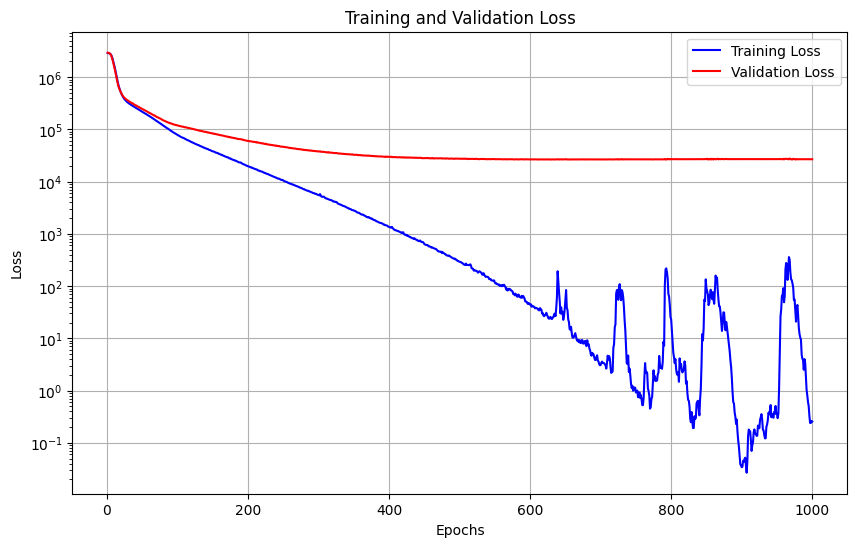

In [77]:
plot_training_history(training_losses, validation_losses)

Sample of 15 predictions vs actual values:
     Actual ELO  Predicted ELO  Absolute Error
74  1739.726074    1837.637817       97.911743
40  1716.276367    1792.602539       76.326172
84  1791.044312    1776.257568       14.786743
52  1742.662842    1699.226562       43.436279
82  1866.621460    1894.671875       28.050415
25  1521.469482    1656.678955      135.209473
65  1639.143921    1902.976196      263.832275
6   1640.042114    1763.585083      123.542969
67  1556.950317    1655.798828       98.848511
34  1665.835327    1520.426147      145.409180
72  1677.777832    1524.796753      152.981079
44  1851.457642    1705.207764      146.249878
24  1696.034180    1538.678711      157.355469
75  1638.607056    1575.593994       63.013062
15  1820.795044    1559.156250      261.638794

Overall Metrics:
Mean Absolute Error (MAE): 124.17
Root Mean Squared Error (RMSE): 152.70


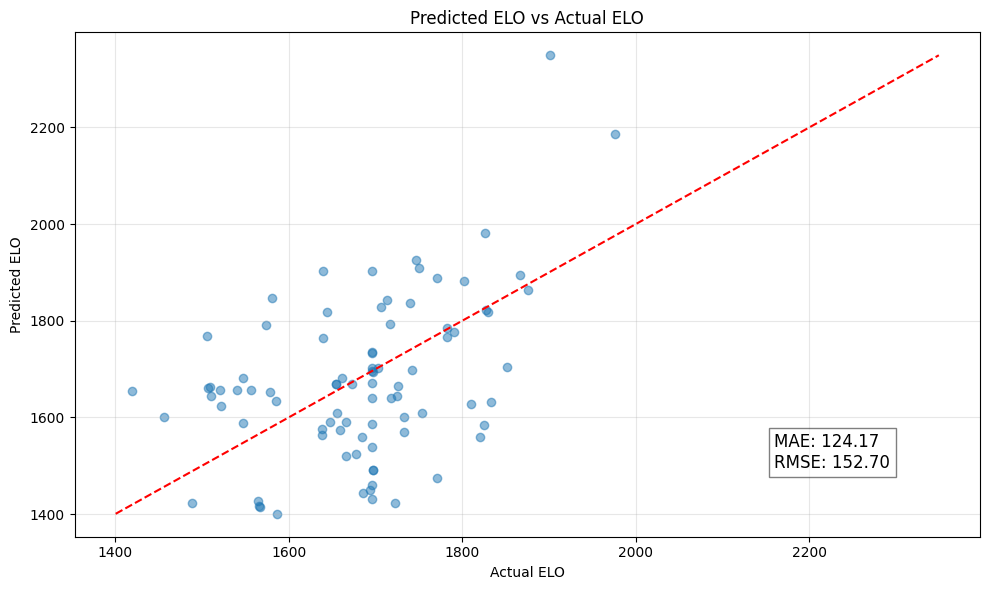

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compare_predictions_to_actual(model, test_dataset, num_samples=10, include_plot=True):
    """
    Compare model predictions with actual target values.
    
    Parameters:
        model: The trained neural network model
        test_dataset: Test dataset (TensorDataset)
        num_samples: Number of examples to show
        include_plot: Whether to include a scatter plot visualization
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get all inputs and targets from the test dataset
    X_test = test_dataset.tensors[0]
    y_test = test_dataset.tensors[1]
    
    # Get predictions for all test samples
    with torch.no_grad():
        predictions = model(X_test).squeeze()
    
    # Convert to numpy for easier handling
    predictions = predictions.numpy()
    actual = y_test.squeeze().numpy()
    
    # Calculate errors
    absolute_errors = np.abs(predictions - actual)
    
    # Create a DataFrame for display
    results_df = pd.DataFrame({
        'Actual ELO': actual,
        'Predicted ELO': predictions,
        'Absolute Error': absolute_errors
    })
    
    # Display a sample of the results
    print(f"Sample of {num_samples} predictions vs actual values:")
    print(results_df.sample(num_samples))
    
    # Calculate and show overall metrics
    mae = np.mean(absolute_errors)
    rmse = np.sqrt(np.mean((predictions - actual) ** 2))
    print(f"\nOverall Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    # Create a scatter plot
    if include_plot:
        plt.figure(figsize=(10, 6))
        
        # Scatter plot of predictions vs actual
        plt.scatter(actual, predictions, alpha=0.5)
        
        # Perfect prediction line (y=x)
        min_val = min(np.min(actual), np.min(predictions))
        max_val = max(np.max(actual), np.max(predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.title('Predicted ELO vs Actual ELO')
        plt.xlabel('Actual ELO')
        plt.ylabel('Predicted ELO')
        plt.grid(True, alpha=0.3)
        
        # Add text with metrics
        plt.text(
            min_val + 0.8 * (max_val - min_val), 
            min_val + 0.1 * (max_val - min_val),
            f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}', 
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.5)
        )
        
        plt.tight_layout()
        plt.show()

# Usage:
compare_predictions_to_actual(model, test_dataset, num_samples=15)